# Algorítmos II - Classificação por geometrica computacional
Nome: Vinícius Braga Freire\
Matricula: 2020054889

Este programa tem o objetivo aplicar os conhecimentos de geometria computacional vistos em sala de aula de maneira prática.

De maneira a tornar a aplicação dos conhecimentos mais intuitiva foi feita a escolha da interdisciplinaridade da geometria computacional (GP) com a inteligência artificial. Neste projeto iremos desenvolver um método de classificação (clássico problema de machine learning) de 2 classes bidimensionais (cada classe possui apenas duas propriedades númericas) usando tecnicas de GP.

Assim, iremos resumir o algoritmo de treinamento da seguinte maneira:
- Separar o conjunto de dados do data set em 70% para treinamento e 30% para testes.
- Com os dados de treinamento, faça para cada uma das duas classes:
  - Gere a envoltória convexa dessa classe
- Posteriormente verifique se as envoltórias se colidem usando o método de varredura.
- Caso haja uma colisão, então aborte o programa pois nenhum modelo pode ser feito a partir desse data set (as classes não são linearmente separáveis)
- Caso contrário, então ache os pontos mais próximos entre as duas envoltórias. Com esse par de pontos deve-se gerar uma reta R que ligue ambos. No ponto médio de R irá passar uma linha L perpendicular a R que será a reta divisória (o modelo calculado) usada para se classificar os pontos de teste.
- Salve essa reta R, afinal ela representa o modelo de classificação treinado em cima desse data set.

A seguir estarão mais detalhes das implementações escolhidas para cada uma dessas operações e suas complexidades. Para as análises de complexidade, considere o padrão em que **N** é o número de pontos de dada classe.

O código será dividido nas seguintes etapas:
- [Primitivas](#primitivas)
- [Operações Avançadas](#op-avan)
- [Importação e exportação de data sets](#in-ex-data)
- [Treinamento do modelo](#treinamento)
- [Classificação de pontos](#classi)
- [Exemplos](#exs)

## <a id="primitivas"></a> Primitivas

Esta seção foi dividida em duas partes:
- [Primitivas geométricas](#primi-geo)
- [AVL](#avl)

A primeira se refere a todas as operações primitivas geométricas usadas em praticamente todas as outras etapas e discorreremos sobre cada uma delas:
- `Point`: Classe para representar um ponto bidimensional com cordenadas em ponto flutuante.
- `Segment`: Classe para representar um segmento no qual tem 2 terminais, um inicial (ponto com menor X) e um final (ponto com maior X), que pertence a alguma das duas classes do modelo de classificação. Assim, possui um atributo para indicar se sua classe é a 1 ou não.
- `SegPoint`: Classe que extende `Point` e também possui links para os segmentos aos quais este ponto faz parte. Assim, esse ponto agora está atrelado não só a segmentos, mas também a uma classe.
- `plotPolygon`: função para plotar um polígono.
- `plotPoints`: função para plotar um conjuntos de pontos.
- `abline`: função para plotar uma reta.
- `isLeft`: primitiva essencial para diversas operações. Verifica se um segmento p1-p2 está a esquerda de p1-p3 ou não. Será a base de diversos algoritmos. Esta função é **O(1)**.
- `direction`: primitiva similar a isLeft, porém permite 3 níveis de direção em vez de 2 (passa a permitir representar retas colineares). Esta função é **O(1)**.
- `onSegment`: primitiva que permite saber se o ponto p2 pertence ao segmento p1-p3 dado que já saibamos que p1, p2 e p3 são colineares. Esta função é **O(1)**.
- `segmentIntersect`: primitiva que verifica se dois segmentos se interceptam. Esta primitiva será usada na varredura linear para verificar colisão entre polígonos. Seu custo é **O(1)**.
- `getAllSegments`: função que, a partir de um polígono (lista de pontos ordenados em sentido anti-horário) retorna todos os segmentos que formam esse polígono. Essa função é **O(N)**.

A segunda se refere a AVL usada no controle da ordem de prioridade de segmentos durante a varredura de pontos.
Como se trata de uma AVL, então toda inserção, remoção, atualização ou procura dos nós imediatamente superiores/inferiores são executados em **O(logN)**.

### <a id="primi-geo"></a> Primitivas geométricas

In [33]:
import functools
import matplotlib.pyplot as plt

# Classe que representa um ponto num plano bidimensional. _vec armazena [x, y]
class Point:
    _vec: [float, float]
    
    def __init__(self, x, y):
        self._vec = [x, y]
    
    def __getitem__(self, i):
        return self._vec[i]

# Classe que representa um segmento. Armazena os 2 pontos e a classe no qual 
# esse segmento pertence
class Segment:
    points: [Point, Point]
    firstClass: bool
    
    def __init__(self, p1, p2, firstClass):
        self.points = [p1, p2]
        self.firstClass = firstClass

# Classe que representa um ponto pertencente a dois segmentos (um ponto de um 
# polígono)
class SegPoint(Point):
    segs: [Segment, Segment]
    
    def __init__(self, p, seg1, seg2):
        self._vec = p
        self.segs = [seg1, seg2]
        
    def getClass(self):
        return self.segs[0].firstClass

# Função que plota no gráfico um polígono
def plotPolygon(polygon: [Point], color, lineType):
    p = np.array(list(map(lambda p: [p[0], p[1]], polygon)))
    plt.plot(p[:,0], p[:,1], color + lineType)
    plt.plot(np.concatenate((p[:,0], [p[0][0]])), np.concatenate((p[:,1], [p[0][1]])), color + lineType)
    
# Função que plota no gráfico um conjunto de pontos
def plotPoints(points: [Point], color, boldFirst = False, label=""):
    if len(points):
        p = np.array(list(map(lambda p: [p[0], p[1]], points)))
        if len(label):
            plt.plot(p[1:len(p), 0], p[1:len(p), 1], color + "o", label=label)
        else:
            plt.plot(p[1:len(p), 0], p[1:len(p), 1], color + "o")
        
        # Destaque do ponto inferior
        if boldFirst:
            plt.plot(p[0][0], p[0][1], 'rx')
        else:
            plt.plot(p[0][0], p[0][1], color + "o")
            
        plt.legend()

# Função que plota uma reta em função de seu coeficiente e de um ponto qualquer
# que pertença a essa reta. Plota tambem este ponto e a equação resultante da reta.
def abline(slope, point: Point, lineType, pointType, label=""):
    axes = plt.gca()
    y_vals, x_vals = np.array(axes.get_ylim()), np.array(axes.get_xlim())
        
    if type(slope) is str:
        new_y_vals = y_vals
        new_x_vals = np.full(y_vals.shape, point[0])
    else:
        new_x_vals = x_vals
        intercept = point[1] - slope * point[0]
        new_y_vals = intercept + slope * x_vals
        
    plt.plot(new_x_vals, new_y_vals, lineType)
    plt.plot(point[0], point[1], pointType, label=label)
    plt.ylim(y_vals)
    plt.xlim(x_vals)
    
    if type(slope) is str:
        plt.annotate('x={0:.3f}'.format(point[0]), 
                     xy=(point[0], y_vals.max()), 
                     color=lineType[0])
    else:
        if slope != 0:
            labelX = (y_vals.max() - intercept) / slope
        else:
            labelX = x_vals.min()
        # Se a reta está limitada em X
        if labelX < x_vals.min():
            labelX = x_vals.min()
            
        labelY = labelX * slope + intercept
        plt.annotate('y={0:.3f}x {2} {1:.3f}'.format(slope, intercept, '+' if intercept >= 0 else ''), 
                     xy=(labelX, labelY),
                     color=lineType[0])
        
    plt.legend()

# Função que define se a reta p1-p2 está a esquerda (anti-horário) de p1-p3 ou não.
# Se as retas forem colineares, então a função retorna como a esquerda.
def isLeft(p1: Point, p2: Point, p3: Point):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1]) <= 0

# Função que define a direção relativa de p1-p2 e p1-p3.
# 0: Colineares
# 1: p1-p2 clockwise em relação a p1-p3
# -1: p1-p2 counter clockwise em relação a p1-p3
def direction(p1: Point, p2: Point, p3: Point):
    vecProd = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1]);
    # Clock wise
    if vecProd > 0:
        return 1
    # Counter clock wise
    elif vecProd < 0:
        return -1
    # Colinear    
    else:
        return 0

# Sabendo que p1,p2 e p3 são colineares:
# Verifica se dado um segmento p1-p3 o ponto p2 pertence a este segmento.
def onSegment(p1: Point, p2: Point, p3: Point):
    if ((p2[0] <= max(p1[0], p3[0])) and (p2[0] >= min(p1[0], p3[0])) and 
        (p2[1] <= max(p1[1], p3[1])) and (p2[1] >= min(p1[1], p3[1]))):
        return True
    return False

# Função que verifica se dois segmentos s1 e s2 se interceptam ou não
def segmentIntersect(s1: Segment, s2: Segment):
    # Se ambos segmentos forem da mesma classe evita calculos desnecessarios
    if s1.firstClass == s2.firstClass:
        return False
    
    p1, q1 = s1.points[0], s1.points[1]
    p2, q2 = s2.points[0], s2.points[1]
    d1 = direction(p1, p2, q1)
    d2 = direction(p1, q2, q1)
    d3 = direction(p2, p1, q2)
    d4 = direction(p2, q1, q2)
    
    if ((d1 != d2) and (d3 != d4)):
            return True
    elif d1 == 0 and  onSegment(p1, p2, q1):
        return True
    elif d1 == 0 and  onSegment(p1, q2, q1):
        return True
    elif d1 == 0 and  onSegment(p2, p1, q2):
        return True
    elif d1 == 0 and  onSegment(p2, q1, q2):
        return True
    return False

# Função que, a partir de um dado polígono, obtem os segmentos formados por esse
# polígono (cada segmento é dado no formato [ponto mais a esquerda, ponto mais a direita])
# e altera os pontos do polígono de forma que esses apontem pra quais segmentos 
# esses fazem parte
# polygon = polígono que se deseja obter os segmentos
# firstClass = indica se esse polígono pertence a primeira classe de classificação ou não
# points = lista que irá ser incrementada com os pontos deste polígono
# segments = lista a ser incrementada com os segmentos deste polígono
def getAllSegments(polygon: [Point], firstClass: bool, points: [SegPoint], segments: [Segment]):
    N = len(polygon)
    M = len(segments)
    # Para cada ponto no polígono
    for i in range(N):
        p1 = polygon[i]
        p2 = polygon[i + 1 if i != N - 1 else 0]
        
        # Faz analise de qual ponto está mais a esquerda/direita e mais acima/abaixo caso X seja igual
        if p1[0] < p2[0]:
            start, endpoint = p1, p2
        elif p1[0] == p2[0]:
            if p1[1] > p2[1]:
                start, endpoint = p1, p2
            else:
                start, endpoint = p2, p1
        else:
            start, endpoint = p2, p1

        # Adiciona o proximo segmento
        segments.append(Segment(start, endpoint, firstClass))
    
    # Para cada novo ponto de um segmento a ser inserido, atrela esse ponto aos seus 2 segmentos
    for i in range(M, M + N):
        p1 = polygon[i - M]
        # Adiciona os pontos
        points.append(SegPoint(p1, segments[i], segments[i - 1 if i != M else M + N - 1]))

### <a id="avl"></a> AVL

In [34]:
# Create a tree node
class TreeNode(object):
    def __init__(self, seg: Segment):
        self.val : [Segment] = [seg]
        self.key = seg.points[0][1]
        self.left = None
        self.right = None
        self.height = 1

class AVLTree(object):
    # Function to insert a node
    def insert_node(self, root, seg: Segment):
        key = seg.points[0][1]
        
        # Find the correct location and insert the node
        if not root:
            return TreeNode(seg)
        elif key < root.key:
            root.left = self.insert_node(root.left, seg)
        elif key > root.key:
            root.right = self.insert_node(root.right, seg)
        # Adiciona o segmento na lista caso já haja um nó com o respectivo Y
        else:
            root.val.append(seg)

        root.height = 1 + max(self.getHeight(root.left), self.getHeight(root.right))

        # Update the balance factor and balance the tree
        balanceFactor = self.getBalance(root)
        if balanceFactor > 1:
            if key < root.left.key:
                return self.rightRotate(root)
            else:
                root.left = self.leftRotate(root.left)
                return self.rightRotate(root)

        if balanceFactor < -1:
            if key > root.right.key:
                return self.leftRotate(root)
            else:
                root.right = self.rightRotate(root.right)
                return self.leftRotate(root)

        return root

    # Function to delete a node
    def delete_node(self, root, seg: Segment):
        key = seg.points[0][1]
        
        # Find the node to be deleted and remove it
        if not root:
            return root
        elif key < root.key:
            root.left = self.delete_node(root.left, seg)
        elif key > root.key:
            root.right = self.delete_node(root.right, seg)
        else:
            # Caso haja mais de um segmento sobre esse Y exclui ele ao em vez do nó inteiro
            if len(root.val) > 1:
                root.val.remove(seg)
                return root
                
            if root.left is None:
                temp = root.right
                root = None
                return temp
            
            elif root.right is None:
                temp = root.left
                root = None
                return temp
            
            temp = self.getMinValueNode(root.right)
            root.key = temp.key
            root.val = temp.val
            root.right = self.delete_node(root.right, temp.val[0])

        # If the tree has only one node,
        # simply return it
        if root is None:
            return root

        # Update the balance factor of nodes
        root.height = 1 + max(self.getHeight(root.left), self.getHeight(root.right))

        balanceFactor = self.getBalance(root)

        # Balance the tree
        if balanceFactor > 1:
            if self.getBalance(root.left) >= 0:
                return self.rightRotate(root)
            else:
                root.left = self.leftRotate(root.left)
                return self.rightRotate(root)
        if balanceFactor < -1:
            if self.getBalance(root.right) <= 0:
                return self.leftRotate(root)
            else:
                root.right = self.rightRotate(root.right)
                return self.leftRotate(root)
        return root

    # Function to perform left rotation
    def leftRotate(self, z):
        y = z.right
        T2 = y.left
        y.left = z
        z.right = T2
        z.height = 1 + max(self.getHeight(z.left), self.getHeight(z.right))
        y.height = 1 + max(self.getHeight(y.left), self.getHeight(y.right))
        return y

    # Function to perform right rotation
    def rightRotate(self, z):
        y = z.left
        T3 = y.right
        y.right = z
        z.left = T3
        z.height = 1 + max(self.getHeight(z.left), self.getHeight(z.right))
        y.height = 1 + max(self.getHeight(y.left), self.getHeight(y.right))
        return y

    # Get the height of the node
    def getHeight(self, root):
        if not root:
            return 0
        return root.height

    # Get balance factore of the node
    def getBalance(self, root):
        if not root:
            return 0
        return self.getHeight(root.left) - self.getHeight(root.right)

    def preOrder(self, root):
        if not root:
            return
        print("{0}[{1}] ".format(root.key, len(root.val)), end="")
        self.preOrder(root.left)
        self.preOrder(root.right)

    # Print the tree
    def printHelper(self, currPtr, indent, last):
        if currPtr != None:
            sys.stdout.write(indent)
            if last:
                sys.stdout.write("R----")
                indent += "     "
            else:
                sys.stdout.write("L----")
                indent += "|    "
            print(currPtr.key)
            self.printHelper(currPtr.left, indent, False)
            self.printHelper(currPtr.right, indent, True)
      
    def getMinValueNode(self, root):
        if root is None or root.left is None:
            return root
        return self.getMinValueNode(root.left)
      
    def findNode(self, root, seg):
        if(root.key == seg.points[0][1]):
            return root
        
        if(root.key > seg.points[0][1]):
            return self.findNode(root.left, seg)
        else:
            return self.findNode(root.right, seg)

    # Função que retorna o primeiro segmento acima do segmento desejado
    def getAbove(self, root, seg):
        def findA(root, seg):
            if root is None:
                return None
            
            key = seg.points[0][1]
            if(root.key > key):
                a = findA(root.left, seg)
                if a is None:
                    return root
                else:
                    return a
            elif(root.key < key):
                return findA(root.right, seg)
            else:
                if(root.right):
                    return root.right
                else:
                    return None
                
        #
        found = findA(root, seg)
        if found is None:
            thisNode = self.findNode(root, seg)
            for s in thisNode.val:
                if s.firstClass != seg.firstClass:
                    return thisNode

        return found
        
    # Função que retorna o primeiro segmento abaixo do segmento desejado
    def getUnder(self, root, seg):        
        def findU(root, seg):
            if root is None:
                return None
            
            key = seg.points[0][1]
            if(root.key > key):
                return findU(root.left, seg)
            elif(root.key < key):
                a = findU(root.right, seg)
                if a is None:
                    return root
                else:
                    return a
            else:
                if(root.left):
                    return root.left
                else:
                    return None
                
        found = findU(root, seg)
        # Se não achou nenhum nó abaixo, tenta procurar nos segmentos que estao
        # no mesmo ponto segmentos que tenham uma classe diferente
        if found is None:
            thisNode = self.findNode(root, seg)
            for s in thisNode.val:
                if s.firstClass != seg.firstClass:
                    return thisNode

        return found

## <a id="op-avan"></a> Operações Avançadas

Nesta seção iremos tratar das operações avançadas de geometria computacional e que usaram das primitivas descritas anteriormente:
- `sortPoints`: função que ordena os pontos no sentido anti-horário em função a um ponto. Esta função usa a primitiva `isLeft` para saber o sentido relativo entre pontos e, assim, ordenar os pontos. Como `isLeft` é **O(1)** e sort é **O(NlogN)**, então essa função é **O(NlogN)**. Ordenar os pontos em um dado sentido é essencial para se achar a envoltória através do algorítmo da envoltória convexa de Graham.
- `getPolygon`: função que obtem o menor polígono que envolve todos os pontos de entrada. Em resumo, essa função executa o algorítmo da envoltória convexa de Graham em tempo **O(NlogN)**. Este método utiliza do algoritmo `sortPoints` descrito anteriormente. Essa função será usada para achar a envoltória de ambas as classes do data set de entrada.
- `isThereColision`: função que verifica, dado o conjunto de pontos das envoltórias da classe 1 e classe 2 do nosso problema de classificação, se há algum par de segmentos de retas (formado por esses pontos) que colidem entre si. A colisão entre esses segmentos só é valida se esses segmentos forem de classes diferentes. Dessa maneira, este algoritmo verifica se há colisão entre dois polígonos diferentes.
  - Nesse método é utilizado o algoritmo de varredura linear para verificar se há colisão entre os segmentos. Para tal, primeiramente os pontos são ordenados em função a cordenada X (esquerda -> direita). Para implementar a ordenação dos pontos a cada evento em função de Y foi utilizada da [AVL](#avl) descrita anteriormente. Esta implementação foi escolhida pois desempenha em **O(NlogN)**.
- `findClosestPoints`: função responsável por achar o par de pontos mais próximo entre si em um dado conjunto de pontos (que já esteja ordenado em função a X). Como estamos lidando com todos os pontos que formam as envoltórias dos polígonos tanto da classe 1 como da classe 2, então modificamos o algoritmo de forma que apenas pares de pontos que sejam de diferentes classes sejam verificados.
  - Neste caso usamos uma implementação de divisão e conquista que custa **O(NlogN)**, pois assim evitamos um algorítmo de força bruta quadrático que causaria um gargalo no treinamento.
- `getClassDivision`: função que, dado um par de pontos, retorna o ponto médio do segmento de reta R que liga ambos e calcula o coeficiente da reta L perpendicular a esta reta R. Este método é usado para achar a reta que divide as duas classes, criando assim um modelo de classificação. Esta função é **O(1)**.

In [35]:
import math
import sys
import copy

MAX_INT = sys.maxsize

# Função que ordena os pontos em sentido anti-horário em relação ao ponto de referencia.
# O ponto de referência ficará na primeira posição do vetor ordenado
# refID = index do ponto de referencia
# points = pontos a serem ordenados
def sortPoints(refID: int, points: [Point]):
    # Coloca o menor na 1 posição
    refCopy = copy.copy(points[refID])
    points[refID] = points[0]
    points[0] = refCopy
    
    # Ordena
    points.sort(key=functools.cmp_to_key(
            lambda p2, p3: 1 if isLeft(refCopy, p2, p3) else -1 
        )
    )

# Função que obtem o polígono da menor envoltória de um dado conjunto de pontos 
# dado o algorítmo da envoltória convexa de Graham.
# points = conjunto de pontos que serão processados
def getPolygon(points: [Point]):
    lowestID = 0
    # Acha o ponto mais abaixo (mais a esquerda em desempate)
    for i in range(1, len(points)):
        point = points[i]
        if (point[1] < points[lowestID][1]) or (point[1] == points[lowestID][1] and point[0] < points[lowestID][0]):
            lowestID = i

    # Ordena os pontos em sentido anti-horário
    sortPoints(lowestID, points)
    
    # Acha a envoltória desses pontos
    polygon = [points[0], points[1]]
    N = len(points)
    for i in range(1, N - 1):
        p1, p2, p3 = polygon[-2], polygon[-1], points[(i + 1 if i < N - 1 else 0)]
        
        if isLeft(p1, p3, p2):
            polygon.append(p3)
        else:
            while(not isLeft(p1, p3, p2)):
                # Pop back
                polygon.pop()
                p1, p2 =  polygon[-2], polygon[-1]
                
            polygon.append(p3)
    
    return polygon

# Função que verifica se há colisão entre segmentos de retas de dois polígonos 
# usando o metodo da varredura de pontos (varredura em X).
# points = conjuntos de todos os pontos que formam as envoltórias dos polígonos 
# da classe 1 e da classe 2 do data set.
def isThereColision(points: [SegPoint]):
    def compare (p1: SegPoint, p2: SegPoint):
        if p1[0] < p2[0]:
            return -1
        elif p1[0] == p2[0]:
            # Em empate, tem prioridade quem tem maior Y
            if p1[1] > p2[1]:
                return -1
            else:
                return 1
        else:
            return 1

    # Ordena baseado no x da esquerda pra direita e em desempate o maior y vem antes 
    points.sort(key = functools.cmp_to_key(compare))
    
    tree = AVLTree()
    root = None

    for point in points:
        # Cada segmento no qual este ponto é o ponto inicial do segmento
        for seg in point.segs:
            # Insere segmento na varredura e ordena baseado no Y de seu ponto mais a esquerda (ponto inicial)
            if point._vec == seg.points[0]:
                # Insere na AVL o segmento
                root = tree.insert_node(root, seg)
                
                # Para cada segmento inserido a partir de um ponto, irei olhar o 
                # primeiro ponto acima dele que NÃO PERTENCE a sua classe e o 
                # primeiro ponto abaixo que NÃO PERTENCE a sua classe
                aboveNode = tree.getAbove(root, seg)
                if aboveNode:
                    # Para cada segmento nesse ponto
                    for s in aboveNode.val:
                        if(segmentIntersect(seg, s)):
                            return True
                    
                underNode = tree.getUnder(root, seg)
                if underNode:
                    for s in underNode.val:
                        if(segmentIntersect(seg, s)):
                            return True
                    
        # Cada segmento no qual este ponto é o ponto final do segmento
        for seg in point.segs:
            if point._vec == seg.points[1]: 
                # Verifica o ponto acima e o ponto abaixo
                aboveNode = tree.getAbove(root, seg)
                underNode = tree.getUnder(root, seg)
                if aboveNode and underNode:
                    for s in underNode.val:
                        for s2 in aboveNode.val:
                            if(segmentIntersect(s, s2)):
                                return True

                #
                root = tree.delete_node(root, seg)
                
    return False

# Função que retorna os 2 pontos mais próximos entre si em um dado conjunto de 
# pontos ordenados. Os pontos desse par a ser retornado devem ser de classes
# diferentes (um deve pertencer a poly1 e outro a poly2).
# points = conjunto de pontos atrelados a segmentos que já estao ordenados em X
def findClosestPoints(points: [SegPoint]):
    # Função que calcula a distancia entre dois pontos
    def find_dist(p1: SegPoint, p2: SegPoint):
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Implementação da busca do par de pontos mais próximos usando força bruta.
    # Retorna uma 2-tupla (distancia, par de pontos) referente aos pontos mais 
    # próximos dado o intervalo de pontos passado.
    # Em casos onde há apenas pontos do mesmo tipo é retornado a tupla (MAX_INT, None)
    def brute_force(arr: [SegPoint]) -> (int, (SegPoint, SegPoint)):
        size = len(arr)

        if arr[0].getClass() != arr[1].getClass():
            minimum_distance = find_dist(arr[0], arr[1])
            target_pair = (arr[0], arr[1])
        else:
            minimum_distance = MAX_INT
            target_pair = None

        if size == 2:
            return minimum_distance, target_pair

        for i in range(0, size):
            for j in range(i + 1, size):
                if arr[i].getClass() != arr[j].getClass():
                    distance = find_dist(arr[i], arr[j])
                    if distance < minimum_distance:
                        minimum_distance = distance
                        target_pair = (arr[i], arr[j])

        return minimum_distance, target_pair

    # Algoritmo de divisão e conquista para encontrar os par de pontos mais 
    # próximos tal que estes sejam de classes distintas.
    def closest_pair(Px: [SegPoint], Py: [SegPoint]):
        sizeX = len(Px)
        if sizeX <= 3:
            return brute_force(Px)

        # Obtem pivot
        midpoint_x = sizeX // 2
        Qx = Px[:midpoint_x]
        Rx = Px[midpoint_x:]
        median_x = Px[midpoint_x]
        Qy,Ry = [], []

        for point in Py:
            if point[0] < int(median_x[0]):
                Qy.append(point)
            else:
                Ry.append(point)

        min_distance_left = closest_pair(Qx, Qy)
        min_distance_right = closest_pair(Rx, Ry)
        min_distance = min_distance_left if min_distance_left[0] < min_distance_right[0] else min_distance_right
        
        x_bar = Qx[-1][0]
        Sy = []
        redutor = min_distance[0]
        
        for y in Py:
            if x_bar - redutor < y[0] < x_bar + redutor:
                Sy.append(y)
        
        sizeY = len(Sy)
        for i in range(sizeY - 1):
            for j in range(i + 1, min(i + 7, sizeY)):
                points = Sy[i]
                points_close = Sy[j]
                dist = find_dist(points, points_close)

                if dist < min_distance[0] and (points.segs[0].firstClass != points_close.segs[0].firstClass):
                    min_distance = dist, (points, points_close)

        return min_distance
    
    # Ordena os pontos também em Y
    py = points.copy()
    py.sort(key = lambda p: p[1])
    
    return closest_pair(points, py)

# Função que, dado um par de pontos, retorna o ponto médio do segmento de reta R
# que liga ambos e calcula o coeficiente da reta L perpendicular a esta reta R. 
# Esta reta L será usada para dividir as duas classes durante a classificação.
# pair = par de pontos
def getClassDivision(pair):
    slope = 1
    # Mantem os pontos ordenados em x
    if pair[0][0] > pair[1][0]:
        pair = (pair[1], pair[0])
    # Temos uma reta perpendicular ao eixo X, logo sua representação será diferente
    elif pair[0][1] == pair[1][1]:
        slope = 'inff'
    
    # Calcula a reta perpendicular a reta dos pontos mais próximos
    middlePoint = Point((pair[0][0] + pair[1][0]) / 2, (pair[0][1] + pair[1][1]) / 2)
    
    if slope == 1:
        den = (pair[1][0] - pair[0][0])
        if den != 0:
            slope = (pair[1][1] - pair[0][1]) / den
            slope = -1 / slope
        else:
            slope = 0
    
    return slope, middlePoint

## <a id="in-ex-data"></a>Importação e exportação de data sets

Nesta seção estão retratadass as funções para:
- gerar datas sets aleatorios
- dividi-los em dados de treino e teste
- salvar estes em formato .csv para uso futuro
- extrair data sets salvos de forma a serem utilizados no treinamento/teste

Decidiu-se abordar os data sets/modelos de forma que estes fiquem salvos em .csv para que, caso seja necessário revisitar um exemplo futuramente estes estejam concisamente salvos.

In [36]:
# Pandas é usado apenas para leitura de arquivos CSV (formato no qual estou salvando meus datasets de exemplo)
import pandas as pd
import sklearn.model_selection as sk
import numpy as np

# Função que busca um dado data set nas pastas ./data/test e ./data/train e 
# retorna os pontos das classes 1 e 2 para treino e teste
def importDataSet(datasetName):
    df = pd.read_csv("./data/train/{0}.csv".format(datasetName))
    # Obtem os nomes das classes desse dataset
    classNames = df["Tipo"].unique()
    
    # Obtem os pontos das classes 1 e 2
    p1 = df[df["Tipo"] == classNames[0]][['X','Y']].values
    p1 = list(map(lambda arr: Point(arr[0], arr[1]), p1))

    p2 = df[df["Tipo"] == classNames[1]][['X','Y']].values
    p2 = list(map(lambda arr: Point(arr[0], arr[1]), p2))
    
    df = pd.read_csv("./data/test/{0}.csv".format(datasetName))
    # Obtem os nomes das classes desse dataset
    classNames = df["Tipo"].unique()
    
    # Obtem os pontos das classes 1 e 2
    p1_test = df[df["Tipo"] == classNames[0]][['X','Y']].values
    p1_test = list(map(lambda arr: Point(arr[0], arr[1]), p1_test))
    p2_test = df[df["Tipo"] == classNames[1]][['X','Y']].values
    p2_test = list(map(lambda arr: Point(arr[0], arr[1]), p2_test))

    return p1, p2, p1_test, p2_test

# Função que gera um dada set aleatorio a partir de algumas métricas.
# N1, N2 = número de pontos
# mean1, mean2 = média dos conjuntos
# cov1, cov2 = covariancia dos dois conjuntos
def generateDataSet(N1, N2, mean1, mean2, cov1, cov2):
    p1 = np.random.multivariate_normal(mean1, cov1, N1)
    p2 = np.random.multivariate_normal(mean2, cov2, N2)
    return p1, p2

# Função que salva um conjunto de pontos de maneira que os pontos são splitados
# em duas porções de 70% e 30%, sendo a primeira para treino e a segunda para teste.
# datasetName = nome dos arquivos que serão armazenados na pasta de train/teste
# name1, name2 = nomes das classes dos dados
# points1, points2 = pontos das respectivas classes
def saveDataset(datasetName, names, points):
    for j in range(0, 2):
        writeType = 'w+' if j == 0 else '+a'
        # Apenas splita os pontos em pontos usados pra treino e para teste
        X_train, X_test, Y_train, Y_test = sk.train_test_split(points[j][:,0],points[j][:,1], test_size=0.3, random_state=42);
        with open("./data/train/{0}.csv".format(datasetName), writeType) as f:
            if(writeType == 'w+'):
                f.write("Tipo,X,Y\n")
            for i in range(len(X_train)):
                f.write("{0},{1},{2}\n".format(names[j], X_train[i], Y_train[i]))

        with open("./data/test/{0}.csv".format(datasetName), writeType) as f:            
            if(writeType == 'w+'):
                f.write("Tipo,X,Y\n")
            for i in range(len(X_test)):
                f.write("{0},{1},{2}\n".format(names[j], X_test[i], Y_test[i]))

# Função que salva o modelo treinado no padrão: 
#   X do ponto médio da reta, Y do ponto médio da reta, coeficiente da reta, 
#   qual classe está acima da reta (quem está à direita em caso de slope = inf)
def saveModel(slope , point: Point, pair: (SegPoint, SegPoint), modelName: str):
    # Define quem está na direita
    if type(slope) is str:
        target = pair[1] if pair[0][0] < pair[1][0] else pair[0]
    else:
        target = pair[1] if pair[0][1] < pair[1][1] else pair[0]
    
    # Se o target for da classe 1, então salva 1, caso contrário salva 2
    whoIsAbove = 1 if target.getClass() else 2
        
    with open("./data/models/{0}.csv".format(modelName), 'w') as f:
        f.write("X,Y,Slope,WhoIsAbove\n".format(point[0], point[1], slope))
        f.write("{0},{1},{2},{3}".format(point[0], point[1], slope, whoIsAbove))

## <a id="treinamento"></a>Treinamento do modelo

Nesta seção é onde o treinamento do modelo de detecção para um dado data set realmente ocorre.

A função `createModel` será a função responsável por isso e podemos resumir suas etapas como:
- Obtem os polígonos (poly1 e poly2) das envoltórias convexas para cada uma das classes através do algoritmo [getPolygon](#op-avan). Assim, executamos duas vezes uma algorítmo de custo **O(NlogN)**, o que resulta em um custo total **O(NlogN)**.
- Em seguida, a partir desses polígonos poly1 e poly2 é obtido um vetor com todos os segmentos que formam estes através da função [getAllSegments](#primi-geo). Como essa função é chamada duas vezes (uma para cada polígono) e cada uma tem custo **O(N)**, então temos um custo **O(N)**.
- Em seguida a função verifica se há colisão entre os dois polígonos gerados através da função [isThereColision](#op-avan). Esta função tem custo  **O(NlogN)**. Caso haja colisão a função é terminada. Caso contrário, então:
  - É achado o par de pontos (de diferentes classes) mais próximos entre si no conjunto total de pontos. Essa operação usa a função [findClosestPoints](#op-avan) e tem custo **O(NlogN)**.
  - A partir desse par de pontos é criado o modelo a partir da função [getClassDivision](#op-avan) que tem custo **O(1)**.
  - Por fim, o modelo é salvo para usos futuros através da função [saveModel](#in-ex-data), que é **O(1)**.

Assim, o custo total desa função é **O(NlogN)**. Neste momento se torna claro porque decidimos implementar `findClosestPoints` através do método da divisão e consquista ao em vez de força bruta, pois assim teríamos um gargalo que tornara o treinamento com custo **O(N^2)**.

In [37]:
# Função que recebe dois conjuntos de pontos (um de cada classe), treina um 
# modelo geometrico de classificação e armazena o modelo treinado na pasta 
# /data/models com o nome especificado por <modelName>
def createModel(p1, p2, modelName):
    # Obtem os polígonos das duas classes para treino
    poly1 = getPolygon(p1)
    poly2 = getPolygon(p2)

    points = []
    segments = []
    # Constroi os pontos apontando para os segmentos a qual esses pertencem
    getAllSegments(poly1, True, points, segments)
    getAllSegments(poly2, False, points, segments)

    plt.axis('equal')
    plt.title('\n')
    plotPoints(p1, 'b', label="Class 1")
    plotPoints(p2, 'm', label="Class 2")
    plotPolygon(poly1, 'g', '--')
    plotPolygon(poly2, 'k', '--')

    # Verifica se tem colisão
    if isThereColision(points):
        print("It's impossible to create a model based on these data since it has colision between polygons!")
    else:
        # Acha o par mais próximo
        dist, pair = findClosestPoints(points)
        plt.plot([pair[0][0], pair[1][0]], [pair[0][1], pair[1][1]], 'r-')
        
        # Acha a reta que divide as duas classes
        slope, middlePoint = getClassDivision(pair)
            
        abline(slope, middlePoint, 'c-', 'ro', label='Middle Point')
        # Salva o modelo na pasta models
        saveModel(slope, middlePoint, pair, modelName)

    plt.show()

## <a id="classi"></a>Classificação de pontos

Nesta seção estão as funções usadas nos testes, ou seja, funções para a predição de qual classe um ponto pertence dado um modelo fornecido:
- `getPointPrediction`: Função que retorna a predição de qual classe o ponto pertence baseado no modelo. Esta função é **O(1)** já que, para se achar a qual classe este ponto deveria pertencer basta fazer a projeção do ponto sobre a reta que divide as classes e verificar se o ponto está acima ou abaixo desta projeção.
- `classifyAndEval`: função que, dado os conjuntos de teste da classe 1 e classe 2 e um modelo dado, faz a predição da classe de cada um desses pontos e verifica se foi um acerto ou um erro. Com essa operação é possível obter as estatísticas de precisão, revocação (recall) e F1 através do número de falsos positivos, falsos negativos, verdadeiros positivos e verdadeiros negativos. Para esses enquadramentos tomou-se o padrão:
  - Os positivos serão pontos da classe 1 e os negativos da classe 2, logo:
      - **Falsos positivos**: Pontos da classe 2 que foram classificados como da classe 1.
      - **Falsos negativos**: Pontos da classe 1 que foram classificados como da classe 2.
      - **Verdadeiros positivos**: Pontos da classe 1 que foram classificados como da classe 1.
      - **Verdadeiros negativos**: Pontos da classe 2 que foram classificados como da classe 2.
  - Assim, esta função é **O(N)**.

In [38]:
from os.path import exists

# Função que retorna a predição de qual classe o ponto pertence baseado no modelo
# Retorna 1 para a classe 1, 2 para a classe 2 e 0 se estiver em cima da reta
def getPointPrediction(point: Point, slope, intercept, middlePoint, whoIsAbove):
    if type(slope) is str:
        # Projeção é o X da reta vertical
        projection = middlePoint[0]
        cordinate = 0
    else:
        # Projeção é o Y que que o ponto deveria ter tomando-se apenas seu X
        projection = point[0] * slope + intercept
        cordinate = 1
    
    # Se o ponto estiver acima (ou direita para inf) da reta
    if(point[cordinate] > projection):
        return whoIsAbove
    # Se o ponto estiver abaixo (ou esquerda para inf) da reta
    elif(point[cordinate] < projection):
        return 3 - whoIsAbove
    # Se o ponto estiver sob a reta
    else:
        return 0

# Função que recupera as regras de detecção de um dado modelo ja existente e 
# testa os pontos dados (points1 e points2) sobre este modelo e avalia o 
# desempenho desse modelo, retornando as métricas:
# (precision, recall, F1)
def classifyAndEval(points1, points2, modelName):
    path = "./data/models/{0}.csv".format(modelName)
    # Se o modelo existe
    if exists(path):
        # Recupera os dados do modelo
        df = pd.read_csv(path)
        middlePoint = Point(df['X'][0], df['Y'][0])
        slope = df['Slope'][0]
        whoIsAbove = df['WhoIsAbove'][0]
        
        intercept = 0 if (type(slope) is str) else (middlePoint[1] - slope * middlePoint[0])

        # Variaveis de métricas
        false_positive, true_positive = 0, 0
        false_negative, true_negative = 0, 0
        fp_vec, tp_vec = [], []
        fn_vec, tn_vec = [], []

        # Neste caso iremos considerar classe p1 como um positivo e a classe p2 como um negativo
        # Pontos sobre a reta nao recebem rótulos, logo não entram na contabilização das metricas
        # Para todos pontos de teste da classe 1
        for p1 in points1:
            predClass = getPointPrediction(p1, slope, intercept, middlePoint, whoIsAbove)
            # Verdadeiro positivo
            if predClass == 1:
                true_positive += 1
                tp_vec.append(p1)
            # Falso negativo
            elif predClass == 2:
                false_negative += 1
                fn_vec.append(p1)

        # Para todos pontos de teste da classe 2
        for p2 in points2:
            predClass = getPointPrediction(p2, slope, intercept, middlePoint, whoIsAbove)
            # Verdadeiro negativo
            if predClass == 2:
                true_negative += 1
                tn_vec.append(p2)
            # Falso positivo
            elif predClass == 1:
                false_positive += 1
                fp_vec.append(p2)

        # Calcula métricas
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        F1 = 2 * (precision * recall) / (precision + recall)
        
        # Plota resultado da classificação
        plt.title("Classification result\n")
        plotPoints(tp_vec, 'b', label="True positives")
        plotPoints(fn_vec, 'c', label='False negatives')
        plotPoints(tn_vec, 'm', label='True negatives')
        plotPoints(fp_vec, 'r', label='False positives')
        abline(slope, middlePoint, 'k-', 'k')
        plt.xlabel('Precision: {0} %\nRecall: {1} %\nF1: {2} %'.format(precision*100, recall*100, F1*100))
        plt.show()
        
        return precision, recall, F1
    else:
        return 'This model doesn\'t exists'

## <a id="exs"></a> Exemplos

Nesta seção iremos demonstrar o funcionamento e resultado dos algorítmos de treino e teste através de alguns data sets. Assim, esta seção busca mostrar alguns detalhes e conclusões sobre eficiencia e eficácia dos métodos e da metodologia implementada para classificação.

A seção foi dividida em duas partes:
- [Criação de Data Set aleatório](#cri-data)
- [Testes e gráficos](#teste-data)

### <a id="cri-data"></a> Criação de Data Set aleatório

Pequeno *code snippet* para criar um data set aleatório a partir da função `generateDataSet`.

C:\Users\vinic\AppData\Local\Temp\ipykernel_13616\140193986.py:37: RuntimeWarning: covariance is not positive-semidefinite.
  p1 = np.random.multivariate_normal(mean1, cov1, N1)


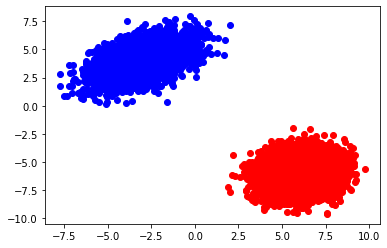

In [39]:
points1, points2 = generateDataSet(3000, 9000, 
                                   [-3,4], [6,-6], 
                                   [[1,-0.2], [-1.85,-1.5]], [[1,.1],[.1,1]])

plt.plot(points1[:,0], points1[:,1], 'bo')
plt.plot(points2[:,0], points2[:,1], 'ro')
plt.show()

### <a id="teste-data"></a> Testes e gráficos

Nesta sub-seção iremos testar o treinamento e teste sobre data sets e iremos fazer análises sobre os resultados obtidos. Para cada data-set será feito o treinamento e logo em seguida o teste, logo toda célula possuirá dois gráficos. 
- O primeiro será o resultado do treinamento (demonstrando a envoltória convexa, todos os pontos, a reta divisiória e os pontos mais próximos).
- O segundo será o resultado do teste, no qual será mostrado a reta e os pontos de teste utilizados. Os pontos terão cores diferentes em função da classe no qual eles foram atribuidos durante a classificação, ficando como padrão:
  - Verdadeiros positivos: Azul
  - Verdadeiros negativos: Magenta
  - Falsos positivos: Vermelho
  - Falsos negativos: Ciano
  
  Abaixo do gráfico de teste estão registradas as métricas (precision, recall e F1) do modelo obtidas após a execução de todos os testes.

Por se tratar de exemplos as vezes com milhoes de pontos, não foi possível colocar todos os data sets no github, logo todos os data sets com seus respectivos nomes estão salvos nesta pasta do [drive](https://drive.google.com/drive/folders/13ziHSpVGGoMvSBF021A0iWX1t6uzGmi1?usp=sharing).

In [32]:
import time

# Função que recebe o nome de um data set e executa o treinamento e teste sobre 
# ele. Caso o usuário deseje, é possível dar criar um data set com os 
# pontos instanciados no momento (através da célula na seção Criação de Data Set aleatório)
def executeTrainAndTest(datasetName, shouldCreate = False):
    start = time.time()
    if shouldCreate:
        saveDataset(datasetName, ["Tipo1", "Tipo2"], [points1, points2])
    p1, p2, p1_test, p2_test = importDataSet(datasetName)

    sP1, sP2 = len(p1) + len(p1_test), len(p2) + len(p2_test)
    sTotal = sP1 + sP2
    print('Data set size: {0} points. {1} for class 1 and {2} for class 2.\n'.format(sTotal, sP1, sP2))

    # Cria modelo
    createModel(p1, p2, datasetName)
    # Usa modelo criado para avaliação e testes
    classifyAndEval(p1_test, p2_test, datasetName)
    
    end = time.time()
    minu = (end - start) // 60
    sec = (end - start) - 60*minu
    print("Time expended: {0:.0f} min {1:.2f} s".format(minu, sec))

#### Exemplo 1

Data set size: 4000 points. 3000 for class 1 and 1000 for class 2.



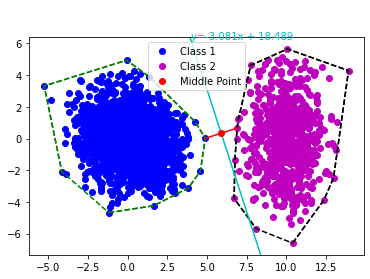

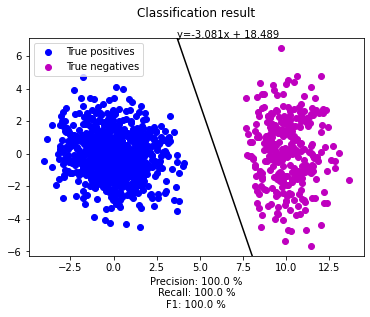

Time expended: 0 min 0.64 s


In [40]:
executeTrainAndTest("exemplo_1")

#### Exemplo 2

Data set size: 4000 points. 3000 for class 1 and 1000 for class 2.



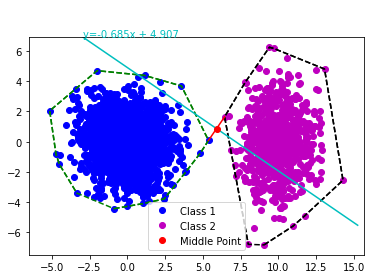

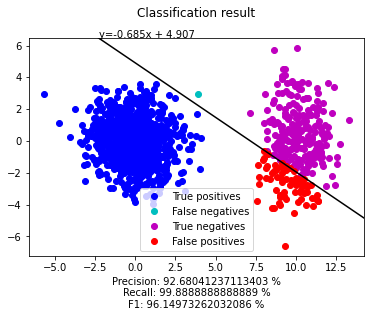

Time expended: 0 min 0.78 s


In [41]:
executeTrainAndTest("exemplo_2")

#### Exemplo 3

Data set size: 4000 points. 3000 for class 1 and 1000 for class 2.



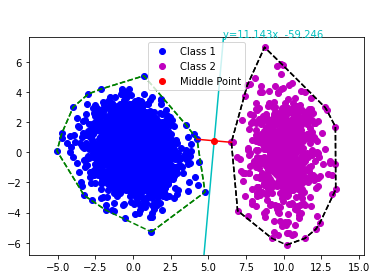

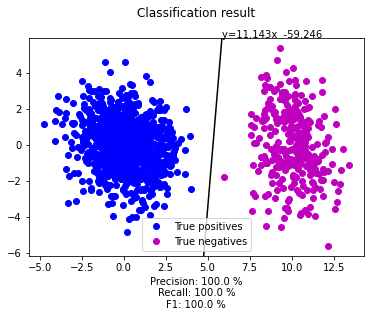

Time expended: 0 min 0.61 s


In [42]:
executeTrainAndTest("exemplo_3")

#### Exemplo 4

Data set size: 40000 points. 30000 for class 1 and 10000 for class 2.



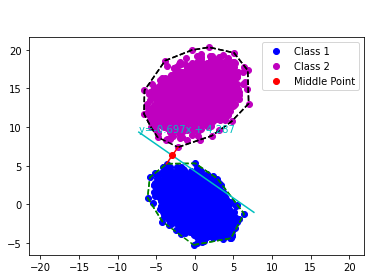

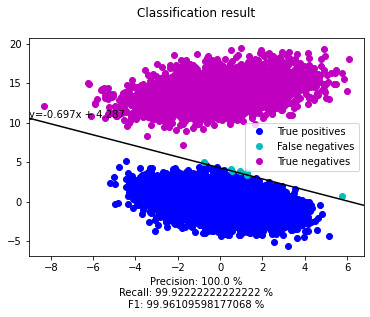

Time expended: 0 min 2.55 s


In [43]:
executeTrainAndTest("exemplo_4")

#### Exemplo 5

Exemplo de data set que gere reta divisória vertical

Data set size: 4001 points. 3000 for class 1 and 1001 for class 2.



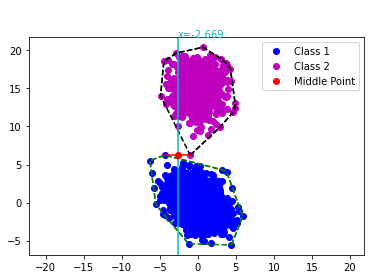

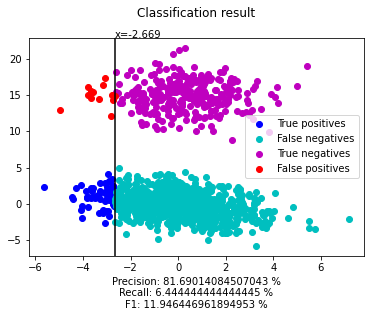

Time expended: 0 min 0.60 s


In [44]:
executeTrainAndTest("vertical_1")

#### Exemplo 6

Exemplo de data set que gere reta divisória horizontal

Data set size: 180 points. 30 for class 1 and 150 for class 2.



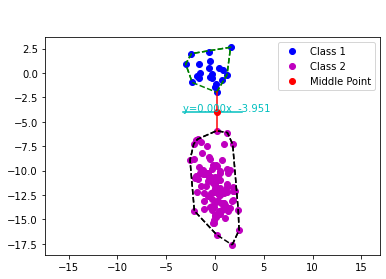

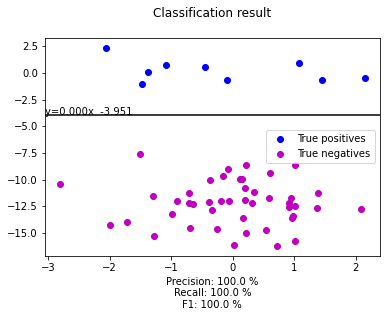

Time expended: 0 min 0.43 s


In [45]:
executeTrainAndTest("horizontal_1")

#### Exemplo 7

Usaremos esse exemplo para mostrar que modelar um problema de classificação utilizando geometria computacional pode ser uma solução bastante sensível à entrada e causar grandes distorções em função de pequenas mudanças.

Data set size: 49000 points. 30000 for class 1 and 19000 for class 2.



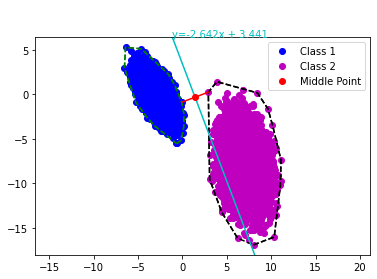

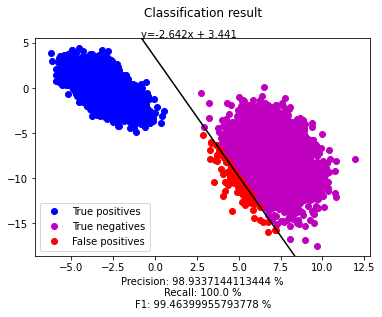

Time expended: 0 min 2.54 s


In [46]:
executeTrainAndTest("exemplo_7")

No exemplo acima temos um modelo criado para esse conjunto de pontos. Iremos adicionar um novo ponto arbritário a esse conjunto de pontos e iremos analisar o que acontece nesse caso.

Data set size: 49001 points. 30001 for class 1 and 19000 for class 2.



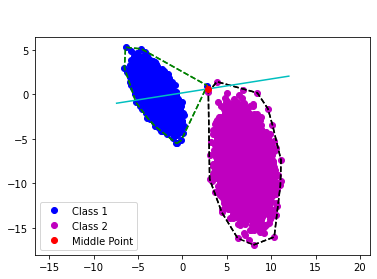

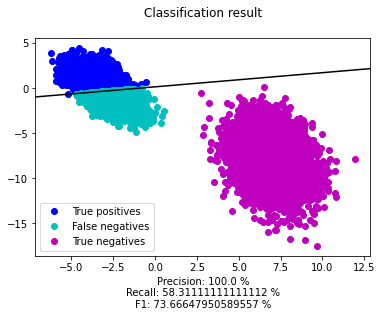

Time expended: 0 min 3.61 s


In [47]:
executeTrainAndTest("exemplo_7_1")

Observamos que ao adicionar apenas um único ponto ao data set de treino mudamos completamente o modelo treinado, reduzindo assim sua qualidade. Assim, notamos que um modelo de classificação baseado unica e exclusivamente em geometria computacional é capaz de gerar modelos precisos, porém ainda assim sensíveis a mudanças pequenas.

#### Exemplo 8

Agora iremos testar nosso algoritmo em data sets extremamente grandes. Nos próximos 2 exemplos, se atente ao tempo demandado para a execução e quantos pontos foram processados em cada data set.

Data set size: 12000000 points. 3000000 for class 1 and 9000000 for class 2.



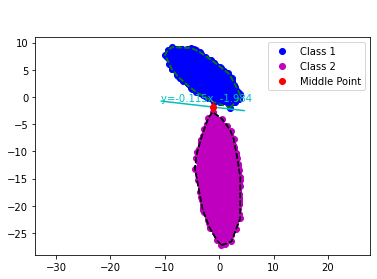

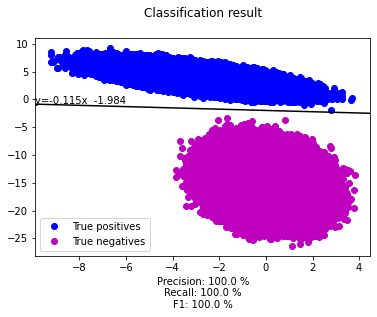

Time expended: 11 min 41.26 s


In [48]:
executeTrainAndTest("exemplo_8")

#### Exemplo 9

Data set size: 12000001 points. 3000000 for class 1 and 9000001 for class 2.



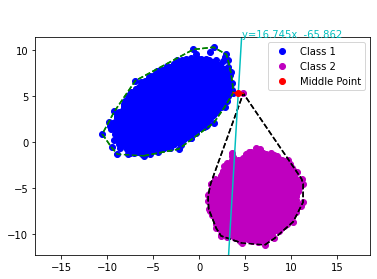

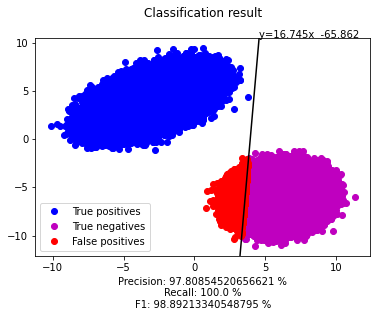

Time expended: 9 min 45.96 s


In [49]:
executeTrainAndTest("exemplo_9")

#### Colisão 1

Data set size: 112 points. 56 for class 1 and 56 for class 2.

It's impossible to create a model based on these data since it has colision between polygons!


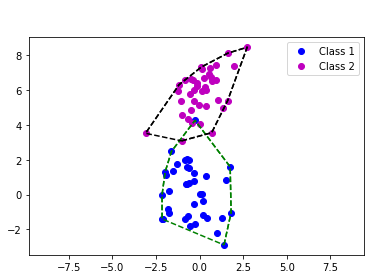

Time expended: 0 min 0.23 s


In [50]:
executeTrainAndTest("colisao_1")

#### Colisao 2

Data set size: 40000 points. 30000 for class 1 and 10000 for class 2.

It's impossible to create a model based on these data since it has colision between polygons!


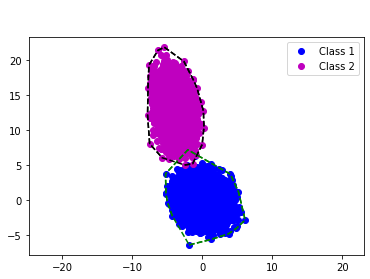

Time expended: 0 min 1.34 s


In [51]:
executeTrainAndTest("colisao_2")

#### Colisao 3

Aqui temos um exemplo de colisão detectado durante o treinamento em um data set grande com mais de 4 milhões de pontos.

Data set size: 4500000 points. 3000000 for class 1 and 1500000 for class 2.

It's impossible to create a model based on these data since it has colision between polygons!


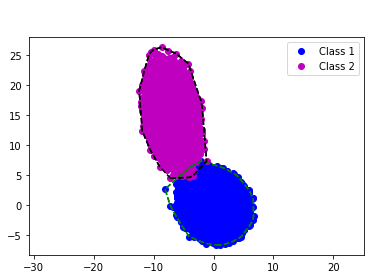

Time expended: 3 min 10.05 s


In [52]:
executeTrainAndTest("colisao_3")

#### Colisao 4

Vemos aqui um exemplo de colisão onde há a colisão concisa de dois pontos das classes, o que embora seja muito pontual, ainda se enquadra como uma colisão.

Data set size: 180 points. 30 for class 1 and 150 for class 2.

It's impossible to create a model based on these data since it has colision between polygons!


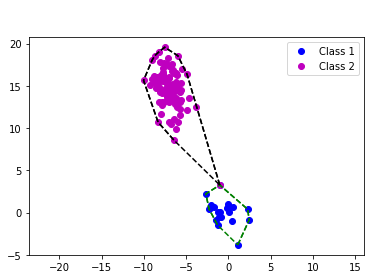

Time expended: 0 min 0.20 s


In [53]:
executeTrainAndTest("colisao_4")

#### Colisao 5

Neste exemplo temos duas retas se sobrepondo, mostrando que isto também é uma colisão.

Data set size: 180 points. 30 for class 1 and 150 for class 2.

It's impossible to create a model based on these data since it has colision between polygons!


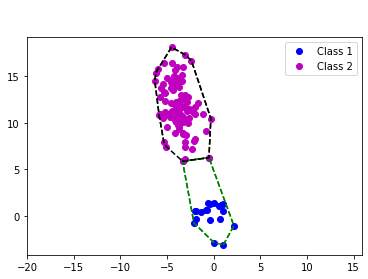

Time expended: 0 min 0.15 s


In [54]:
executeTrainAndTest("colisao_5")